In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

2023-12-28 18:20:04.732432: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 18:20:04.732500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 18:20:04.733222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 18:20:04.737517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-28 18:20:05.402406: W tensorflow/compiler/tf2

In [2]:
import pathlib

dataset_url = 'http://vision.stanford.edu/aditya86/ImageNetDogs'
data_dir = tf.keras.utils.get_file("images.tar", origin = dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [3]:
import os
import re

def rename_folders(folder_path):
    """ Renames the folders with dogs' pictures """
    for folder_name in os.listdir(folder_path):
        new_folder_name = re.sub(r'n\d+-', '', folder_name)
        new_folder_name = re.sub(r'_', ' ', new_folder_name)
        new_folder_name = new_folder_name[0].capitalize()+new_folder_name[1:]
        os.rename(os.path.join(folder_path, folder_name),
                  os.path.join(folder_path, new_folder_name))

In [4]:
# rename_folders('Dogs Breegs/images')

In [5]:
batch_size = 32
img_height = 256
img_width = 256

In [6]:
directory = 'Dogs Breegs/images'
train_ds = tf.keras.utils.image_dataset_from_directory(directory,
                                                       validation_split = 0.2,
                                                       subset = 'training',
                                                       seed = 42,
                                                       image_size = (img_height, img_width),
                                                       batch_size = batch_size)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


2023-12-28 18:20:08.957105: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-28 18:20:08.979366: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-28 18:20:08.979421: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-28 18:20:08.981770: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-28 18:20:08.981820: I external/local_xla/xla/stream_executor

In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(directory,
                                                       validation_split = 0.2,
                                                       subset = 'validation',
                                                       seed = 42,
                                                       image_size = (img_height, img_width),
                                                       batch_size = batch_size)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Affenpinscher', 'Afghan hound', 'African hunting dog', 'Airedale', 'American Staffordshire terrier', 'Appenzeller', 'Australian terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington terrier', 'Bernese mountain dog', 'Black-and-tan coonhound', 'Blenheim spaniel', 'Bloodhound', 'Bluetick', 'Border collie', 'Border terrier', 'Borzoi', 'Boston bull', 'Bouvier des Flandres', 'Boxer', 'Brabancon griffon', 'Briard', 'Brittany spaniel', 'Bull mastiff', 'Cairn', 'Cardigan', 'Chesapeake Bay retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker spaniel', 'Collie', 'Curly-coated retriever', 'Dandie Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English foxhound', 'English setter', 'English springer', 'EntleBucher', 'Eskimo dog', 'Flat-coated retriever', 'French bulldog', 'German shepherd', 'German short-haired pointer', 'Giant schnauzer', 'Golden retriever', 'Gordon setter', 'Great Dane', 'Great Pyrenees', 'Greater Swiss Mountain dog', 'Groenendael', 'Ibizan hound', 'Irish setter', 'Irish terrier', 'Iris

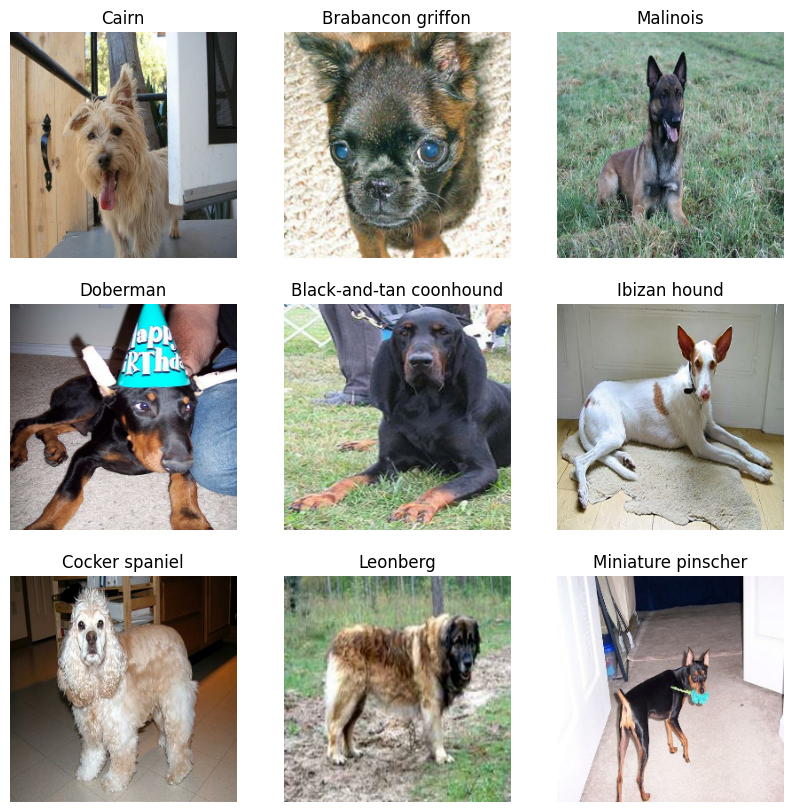

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
""" AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) """

' AUTOTUNE = tf.data.AUTOTUNE\n\ntrain_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)\nval_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) '

In [11]:
normalization_layer = Rescaling(1./255)

flip_layer = RandomFlip('horizontal', 
                               input_shape = (img_height, img_width, 3))
rotation_layer = RandomRotation(0.2)
zoom_layer = RandomZoom(0.2)
crop_layer = RandomCrop(img_height, img_width)
translation_layer = RandomTranslation(0.1, 0.1)

In [12]:
data_augmentation = Sequential([
    flip_layer,
    rotation_layer,
    zoom_layer,
    crop_layer,
    translation_layer
])

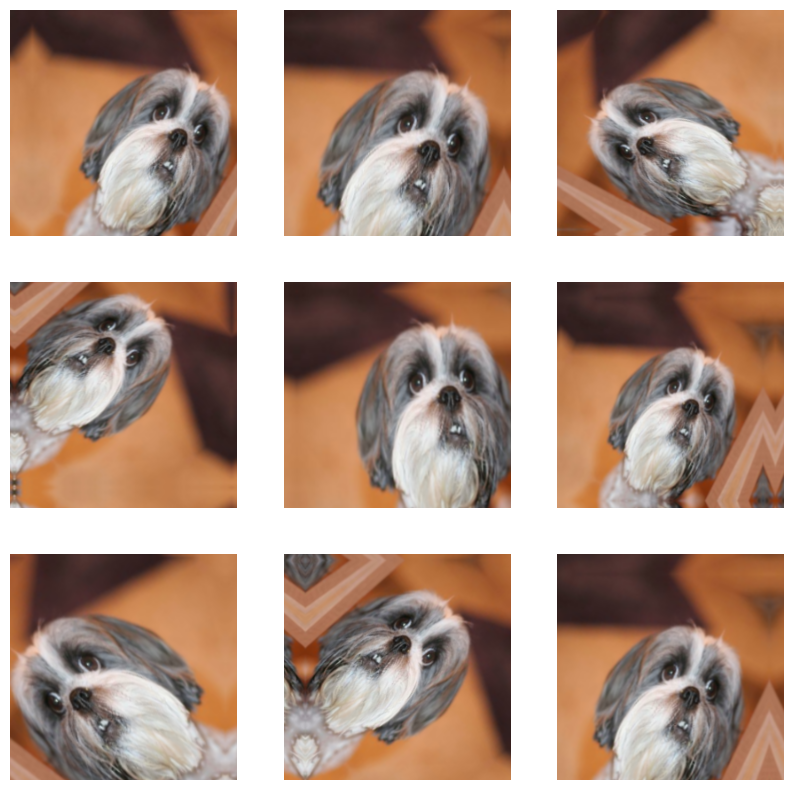

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [15]:
num_classes = len(class_names)
# Создаем Sequential модель
model = Sequential()

# Добавляем входной слой
model.add(InputLayer(input_shape=(img_height, img_width, 3)))

# Применяем аугментацию данных и нормализацию
model.add(RandomFlip('horizontal'))
model.add(RandomRotation(0.2))
model.add(RandomZoom(0.2))
model.add(RandomCrop(img_height, img_width))
model.add(RandomTranslation(0.1, 0.1))
model.add(Rescaling(1./255))

# Добавляем свои слои модели
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax', name="outputs"))

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  normalization_layer,
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation = 'softmax', name="outputs")
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
epochs=30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


2023-12-28 18:21:43.658458: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-28 18:21:43.854080: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-28 18:21:46.459004: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f558c902850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-28 18:21:46.459055: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-12-28 18:21:46.468749: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703812906.555474  203272 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


515/515 [==============================] - 169s 300ms/step - loss: 4.7331 - accuracy: 0.0157 - val_loss: 4.5717 - val_accuracy: 0.0224
Epoch 2/30
515/515 [==============================] - 140s 272ms/step - loss: 4.4649 - accuracy: 0.0282 - val_loss: 4.4038 - val_accuracy: 0.0292
Epoch 3/30
515/515 [==============================] - 141s 273ms/step - loss: 4.3657 - accuracy: 0.0388 - val_loss: 4.3040 - val_accuracy: 0.0381
Epoch 4/30
515/515 [==============================] - 141s 273ms/step - loss: 4.2770 - accuracy: 0.0489 - val_loss: 4.2290 - val_accuracy: 0.0530
Epoch 5/30
515/515 [==============================] - 141s 274ms/step - loss: 4.2063 - accuracy: 0.0591 - val_loss: 4.2305 - val_accuracy: 0.0542
Epoch 6/30
515/515 [==============================] - 140s 273ms/step - loss: 4.1386 - accuracy: 0.0680 - val_loss: 4.0994 - val_accuracy: 0.0756
Epoch 7/30
515/515 [==============================] - 137s 265ms/step - loss: 4.0833 - accuracy: 0.0737 - val_loss: 4.0620 - val_accura

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_2 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_crop_2 (RandomCrop)  (None, 256, 256, 3)       0         
                                                                 
 random_translation_2 (Rand  (None, 256, 256, 3)       0         
 omTranslation)                                                  
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)      

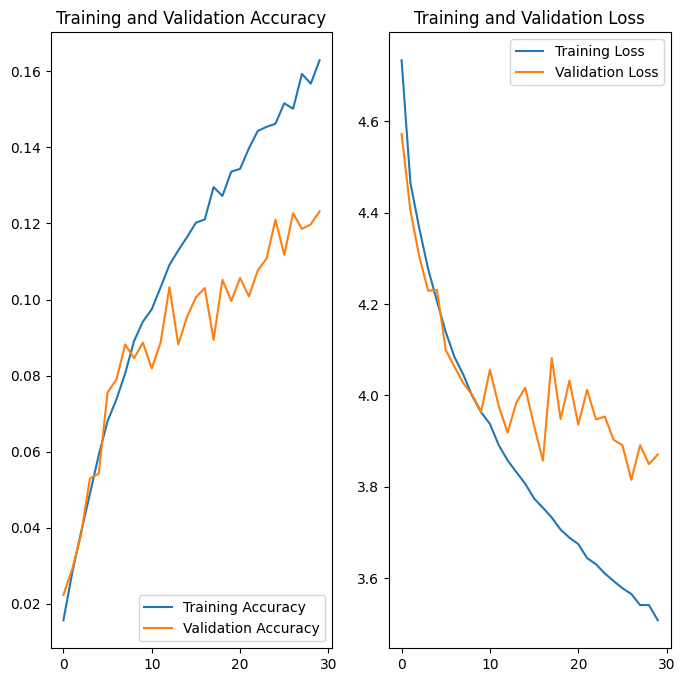

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

(-0.5, 210.5, 147.5, -0.5)

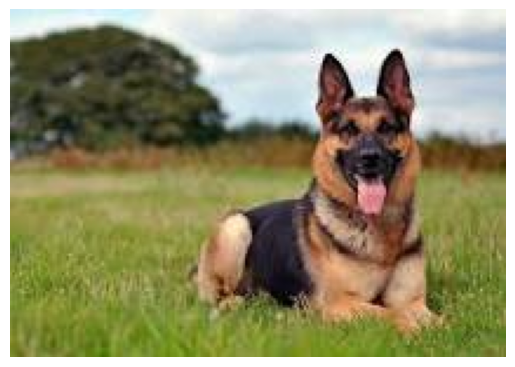

In [20]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

steak = mpimg.imread('images.jpeg')
plt.imshow(steak)
plt.axis(False)

In [30]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape = 224):
    """ Reads an image from filename, turnes it into a tensor and reshapes it
     to (img_shape, img_shape, colour_channels) 
     """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode the read file into a tensor
    img = tf.image.decode_image(img)
    # Resize the image
    img = tf.image.resize(img, size = [img_height, img_width])
    # Rescale the image (get all values between 0 and 1)
    #img = img/255.
    return img

In [36]:
# Load in and preprocess our custom image
item = load_and_prep_image('images.jpeg')
item

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[201.      , 234.      , 243.      ],
        [201.      , 234.      , 243.      ],
        [201.56055 , 234.56055 , 243.56055 ],
        ...,
        [240.      , 246.      , 235.1211  ],
        [240.      , 246.      , 234.      ],
        [240.      , 246.      , 234.      ]],

       [[202.10156 , 234.      , 242.63281 ],
        [201.56082 , 234.27037 , 242.63281 ],
        [202.33939 , 234.72191 , 243.19336 ],
        ...,
        [240.36719 , 246.36719 , 235.48828 ],
        [240.36719 , 246.36719 , 234.36719 ],
        [240.36719 , 246.36719 , 234.36719 ]],

       [[203.83594 , 234.      , 242.05469 ],
        [202.44382 , 234.69606 , 242.05469 ],
        [203.56564 , 234.97597 , 242.61523 ],
        ...,
        [240.94531 , 246.94531 , 236.0664  ],
        [240.94531 , 246.94531 , 234.94531 ],
        [240.94531 , 246.94531 , 234.94531 ]],

       ...,

       [[120.21875 , 137.21875 ,  41.21875 ],
        [117.

In [37]:
pred = model.predict(tf.expand_dims(item, axis = 0))

1/1 [==============================] - 0s 22ms/step


In [38]:
pred

array([[4.8881758e-04, 5.0470736e-02, 5.1072668e-05, 4.6761882e-02,
        4.8709544e-03, 3.2801421e-03, 3.1688579e-03, 1.5372529e-03,
        6.6630505e-03, 3.7629867e-03, 1.2293286e-03, 8.4456941e-03,
        1.5311105e-02, 6.8088448e-05, 1.2646227e-01, 2.2541476e-02,
        1.3913044e-03, 9.0180393e-03, 1.6675524e-03, 2.1136582e-03,
        5.7925750e-04, 7.1181152e-03, 2.4953904e-03, 1.2829849e-02,
        1.9142334e-04, 8.0289198e-03, 5.5992128e-03, 3.9158277e-03,
        4.1378744e-02, 2.2719626e-03, 3.4267872e-04, 5.2370253e-04,
        8.8802079e-04, 6.6587017e-05, 1.6843311e-03, 3.2174003e-03,
        1.6334097e-04, 2.1957880e-05, 6.3851900e-02, 1.3456612e-03,
        4.0654764e-03, 4.8264745e-04, 2.1767758e-02, 1.6824850e-03,
        1.0275643e-03, 8.9958688e-04, 8.0075068e-03, 1.2234142e-03,
        4.7419528e-03, 1.6274957e-03, 1.7698824e-02, 4.0604774e-02,
        1.3850922e-03, 1.3257442e-02, 5.2454025e-03, 1.7491422e-03,
        2.3294400e-02, 1.4325402e-02, 7.2120940e

In [39]:
np.argmax(pred)

14

In [40]:
class_names[np.argmax(pred)]

'Bloodhound'